In [1]:
%matplotlib notebook
import importlib
from matplotlib import pyplot as plt
from input_encoding.population_coding.utils import gaussian, gen_population_coding
import lvq.lvq3
import lvq.lvq4
from lvq.lvq3 import LVQ3
from lvq.lvq4 import LVQ4
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from som import SOM

In [2]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/coil20_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [3]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/strided_coil20.npy', 'rb') as f:
    stride_filtered = np.load(f, allow_pickle=True)

In [4]:
scaled_input = 100 * stride_filtered
scaled_input = scaled_input.reshape((scaled_input.shape[0], stride_filtered.shape[1],-1))
print(scaled_input.shape)
flat_input=scaled_input.reshape((scaled_input.shape[0], -1))
print(flat_input.shape)

(1440, 8, 441)
(1440, 3528)


In [5]:
# Bound the feature to the [0,200] range simulating the rate code range
vmax=350
vmin=30
noise_max=100
bounded = scaled_input.copy()
bounded[bounded<vmin]=0  # below 10, no spike
bounded[bounded>vmax]=vmax # above 200, rate code saturates

# Calculate the noise value for each patch
sum_per_patch = bounded.sum(1)
noise = noise_max - sum_per_patch
noise[noise<0]=0 # also bounded in the range of [0,200]

# Append this noise feature to our feature vectors
bounded=np.append(bounded, noise[:,np.newaxis, :], axis=1)
print(bounded.shape) # new noise feature is now added

flat_bounded=bounded.reshape((bounded.shape[0], bounded.shape[1]*bounded.shape[2]))
print(flat_bounded.shape)

(1440, 9, 441)
(1440, 3969)


In [126]:
X = flat_bounded
y = labels

tasks = []
n_tasks = 20
n_class = 20
n_obj_per_task = int(n_class/n_tasks)

n_sample_per_class = int(X.shape[0]/n_class)
training_ratio = 0.38
n_class = 20

n_tr_sample_per_class = int(n_sample_per_class*training_ratio)

    
for t in range(n_tasks):
    task_mask = np.where((y<n_obj_per_task*(t+1)) & (y>=n_obj_per_task*t))[0]
    X_task = X[task_mask,:]
    y_task = y[task_mask]
    
    mask = list(range(0,X_task.shape[0],int(1/training_ratio)))
    X_train = X_task[mask]
    X_test = np.delete(X_task, mask, axis=0)
    y_train = y_task[mask]
    y_test = np.delete(y_task, mask, axis=0)
    
    tasks.append([X_train, y_train,X_test,y_test])

In [180]:
importlib.reload(lvq.lvq4)
from lvq.lvq4 import LVQ4

n_epochs = 2
n_loop = 1
alpha_decay = 'linear'
n_protos = 400
alpha_start = 0.5
tau_alpha_dc = 2
tau_alpha_gr = 23


accs = np.zeros(shape=(n_tasks,n_tasks*n_loop))

mlvq = LVQ4(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
            n_protos=n_protos, 
            n_class=n_class, 
            alpha_start=alpha_start,
            rec_alpha_evolve=True)

mlvq.init_prototypes_from_data(X)

for loop in range(n_loop):
    for t in range(n_tasks):
        X_train = tasks[t][0]
        y_train = tasks[t][1]
        X_test = tasks[t][2]   
        y_test = tasks[t][3]


        mlvq.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                              tau_alpha_dc=tau_alpha_dc, tau_alpha_gr=tau_alpha_gr, n_epochs=n_epochs, 
                              test_each_epoch=False, shuffle=False, max_allowed_mist=1)

        for test_task in range(n_tasks):
            test_acc = mlvq.predict(tasks[test_task][2], tasks[test_task][3])
            print("task ", test_task, " acc: ", test_acc)
            accs[test_task,loop*n_tasks+t] = test_acc
            
    print("Overall test accuracy: ", np.mean(accs[:,loop*n_tasks+n_tasks-1]))



>epoch=0, lrate=0.500, tr_err=0.000, test_err=0.000
>epoch=1, lrate=0.500, tr_err=0.000, test_err=0.028
task  0  acc:  0.9722222222222222
task  1  acc:  0.0
task  2  acc:  0.0
task  3  acc:  0.0
task  4  acc:  0.0
task  5  acc:  0.0
task  6  acc:  0.0
task  7  acc:  0.0
task  8  acc:  0.0
task  9  acc:  0.0
task  10  acc:  0.0
task  11  acc:  0.0
task  12  acc:  0.0
task  13  acc:  0.0
task  14  acc:  0.0
task  15  acc:  0.0
task  16  acc:  0.0
task  17  acc:  0.0
task  18  acc:  0.0
task  19  acc:  0.0
>epoch=0, lrate=0.500, tr_err=0.056, test_err=0.000
>epoch=1, lrate=0.500, tr_err=0.000, test_err=0.028
task  0  acc:  1.0
task  1  acc:  0.9722222222222222
task  2  acc:  0.0
task  3  acc:  0.0
task  4  acc:  0.0
task  5  acc:  0.0
task  6  acc:  0.0
task  7  acc:  0.0
task  8  acc:  0.0
task  9  acc:  0.0
task  10  acc:  0.0
task  11  acc:  0.0
task  12  acc:  0.0
task  13  acc:  0.0
task  14  acc:  0.0
task  15  acc:  0.0
task  16  acc:  0.0
task  17  acc:  0.0
task  18  acc:  0.0
ta

task  10  acc:  1.0
task  11  acc:  1.0
task  12  acc:  1.0
task  13  acc:  1.0
task  14  acc:  1.0
task  15  acc:  0.0
task  16  acc:  0.0
task  17  acc:  0.0
task  18  acc:  0.0
task  19  acc:  0.0
>epoch=0, lrate=0.001, tr_err=0.083, test_err=0.000
>epoch=1, lrate=0.000, tr_err=0.000, test_err=0.000
task  0  acc:  1.0
task  1  acc:  0.9722222222222222
task  2  acc:  0.8611111111111112
task  3  acc:  1.0
task  4  acc:  0.9166666666666666
task  5  acc:  0.9166666666666666
task  6  acc:  0.8888888888888888
task  7  acc:  0.8888888888888888
task  8  acc:  0.9444444444444444
task  9  acc:  0.9444444444444444
task  10  acc:  1.0
task  11  acc:  1.0
task  12  acc:  1.0
task  13  acc:  1.0
task  14  acc:  1.0
task  15  acc:  1.0
task  16  acc:  0.0
task  17  acc:  0.0
task  18  acc:  0.0
task  19  acc:  0.0
>epoch=0, lrate=0.001, tr_err=0.083, test_err=0.000
>epoch=1, lrate=0.000, tr_err=0.000, test_err=0.000
task  0  acc:  1.0
task  1  acc:  0.9722222222222222
task  2  acc:  0.861111111111

<IPython.core.display.Javascript object>


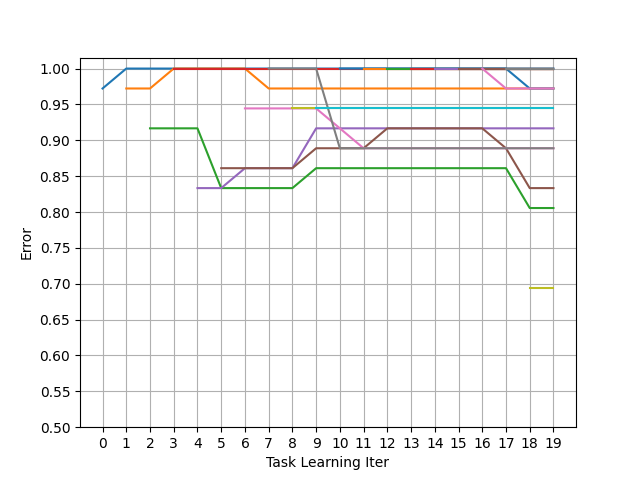

Text(0, 0.5, 'Error')

In [181]:
plt.figure()
for t in range(n_tasks):
    plt.plot(np.arange(t,n_tasks*n_loop),accs[t,np.arange(t,n_tasks*n_loop)])
plt.yticks(np.arange(0.5,1.05,0.05))
plt.xticks(np.arange(20))

plt.grid()

# plt.legend(["Task 1",
#            "Task 2",
#            "Task 3",
#            "Task 4",
#            "Task 5"])
plt.xlabel("Task Learning Iter")
plt.ylabel("Error")
# plt.title("Train/Test error: Coil20 Gabor processed dataset - 12 Prototype per class")

In [108]:
importlib.reload(lvq.lvq4)
from lvq.lvq4 import LVQ4

n_epochs = 1
n_loop = 1
alpha_decay = 'linear'
n_protos = 300
alpha_start = 0.5
tau_alpha_dc_list = np.arange(1,11,2)
tau_alpha_gr_list = np.arange(11,27,2)


# mlvq.init_prototypes_from_data(X)
mean_accs = np.zeros((len(tau_alpha_gr_list),len(tau_alpha_dc_list)))
for dc, tau_alpha_dc in enumerate(tau_alpha_dc_list):
    for gr, tau_alpha_gr in enumerate(tau_alpha_gr_list):
        
        accs = np.zeros(shape=(n_tasks,n_tasks*n_loop))

        mlvq = LVQ4(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                    n_protos=n_protos, 
                    n_class=n_class, 
                    alpha_start=alpha_start,
                    rec_alpha_evolve=False)
        
        for loop in range(n_loop):
            for t in range(n_tasks):
                X_train = tasks[t][0]
                y_train = tasks[t][1]
                X_test = tasks[t][2]   
                y_test = tasks[t][3]


                mlvq.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                                      tau_alpha_dc=tau_alpha_dc, tau_alpha_gr=tau_alpha_gr, n_epochs=n_epochs, 
                                      test_each_epoch=False, shuffle=False, max_allowed_mist=3)

                for test_task in range(n_tasks):
                    test_acc = mlvq.predict(tasks[test_task][2], tasks[test_task][3])
#                     print("task ", test_task, " acc: ", test_acc)
                    accs[test_task,loop*n_tasks+t] = test_acc
            mean_task_acc = np.mean(accs[:,loop*n_tasks+n_tasks-1])
            print("Overall test accuracy: ",mean_task_acc )
        mean_accs[gr,dc] = mean_task_acc


>epoch=0, lrate=0.000, tr_err=0.069, test_err=0.500
>epoch=0, lrate=0.000, tr_err=0.486, test_err=0.028
>epoch=0, lrate=0.000, tr_err=1.458, test_err=0.139
>epoch=0, lrate=0.000, tr_err=0.556, test_err=0.000
>epoch=0, lrate=0.000, tr_err=1.250, test_err=0.028
>epoch=0, lrate=0.000, tr_err=0.347, test_err=0.208
>epoch=0, lrate=0.000, tr_err=1.250, test_err=0.014
>epoch=0, lrate=0.000, tr_err=0.208, test_err=0.000
>epoch=0, lrate=0.000, tr_err=0.347, test_err=0.042
>epoch=0, lrate=0.000, tr_err=1.806, test_err=0.125
Overall test accuracy:  0.7208333333333333
>epoch=0, lrate=0.000, tr_err=0.069, test_err=0.500
>epoch=0, lrate=0.000, tr_err=0.486, test_err=0.042
>epoch=0, lrate=0.000, tr_err=1.528, test_err=0.139
>epoch=0, lrate=0.000, tr_err=0.625, test_err=0.028
>epoch=0, lrate=0.000, tr_err=1.319, test_err=0.028
>epoch=0, lrate=0.000, tr_err=0.278, test_err=0.250
>epoch=0, lrate=0.000, tr_err=1.181, test_err=0.028
>epoch=0, lrate=0.000, tr_err=0.139, test_err=0.000
>epoch=0, lrate=0.000

>epoch=0, lrate=0.000, tr_err=0.347, test_err=0.069
>epoch=0, lrate=0.000, tr_err=1.806, test_err=0.181
Overall test accuracy:  0.8416666666666666
>epoch=0, lrate=0.000, tr_err=2.069, test_err=0.083
>epoch=0, lrate=0.000, tr_err=0.972, test_err=0.014
>epoch=0, lrate=0.000, tr_err=1.806, test_err=0.069
>epoch=0, lrate=0.000, tr_err=1.569, test_err=0.028
>epoch=0, lrate=0.000, tr_err=1.597, test_err=0.028
>epoch=0, lrate=0.000, tr_err=0.833, test_err=0.000
>epoch=0, lrate=0.000, tr_err=1.181, test_err=0.014
>epoch=0, lrate=0.000, tr_err=0.139, test_err=0.000
>epoch=0, lrate=0.000, tr_err=0.278, test_err=0.278
>epoch=0, lrate=0.000, tr_err=1.806, test_err=0.125
Overall test accuracy:  0.8444444444444444
>epoch=0, lrate=0.000, tr_err=0.806, test_err=0.028
>epoch=0, lrate=0.000, tr_err=0.542, test_err=0.069
>epoch=0, lrate=0.000, tr_err=1.389, test_err=0.222
>epoch=0, lrate=0.000, tr_err=1.167, test_err=0.069
>epoch=0, lrate=0.000, tr_err=1.528, test_err=0.014
>epoch=0, lrate=0.000, tr_err=

>epoch=0, lrate=0.003, tr_err=1.389, test_err=0.042
>epoch=0, lrate=0.003, tr_err=0.278, test_err=0.139
>epoch=0, lrate=0.003, tr_err=1.167, test_err=0.042
>epoch=0, lrate=0.003, tr_err=0.139, test_err=0.000
>epoch=0, lrate=0.003, tr_err=0.347, test_err=0.069
>epoch=0, lrate=0.003, tr_err=1.653, test_err=0.111
Overall test accuracy:  0.7375
>epoch=0, lrate=0.002, tr_err=0.639, test_err=0.014
>epoch=0, lrate=0.002, tr_err=0.444, test_err=0.278
>epoch=0, lrate=0.002, tr_err=1.417, test_err=0.167
>epoch=0, lrate=0.003, tr_err=0.764, test_err=0.014
>epoch=0, lrate=0.003, tr_err=1.347, test_err=0.000
>epoch=0, lrate=0.003, tr_err=0.319, test_err=0.236
>epoch=0, lrate=0.003, tr_err=1.181, test_err=0.014
>epoch=0, lrate=0.003, tr_err=0.208, test_err=0.000
>epoch=0, lrate=0.003, tr_err=0.347, test_err=0.069
>epoch=0, lrate=0.003, tr_err=1.736, test_err=0.125
Overall test accuracy:  0.7333333333333333
>epoch=0, lrate=0.002, tr_err=0.681, test_err=0.014
>epoch=0, lrate=0.002, tr_err=0.653, test_

<IPython.core.display.Javascript object>


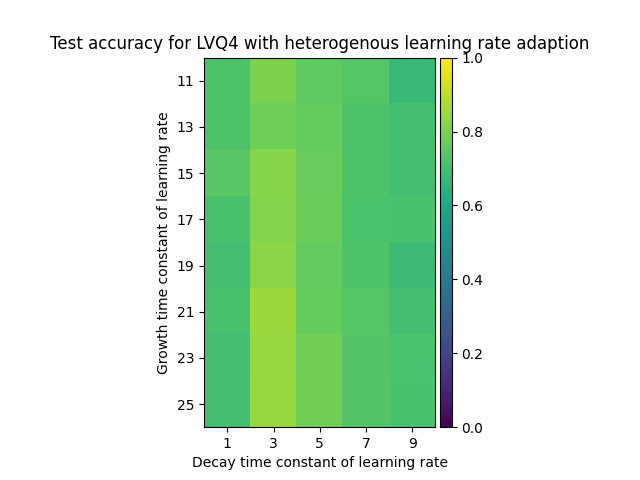

In [109]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()
im=plt.imshow(mean_accs, vmin=0, vmax=1)
ax = fig.axes[0]
plt.ylabel("Growth time constant of learning rate")
plt.xlabel("Decay time constant of learning rate")

plt.xticks(ticks=np.arange(len(tau_alpha_dc_list)),labels=tau_alpha_dc_list)
plt.yticks(np.arange(len(tau_alpha_gr_list)),tau_alpha_gr_list)
plt.title("Test accuracy for LVQ4 with heterogenous learning rate adaption")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

<IPython.core.display.Javascript object>


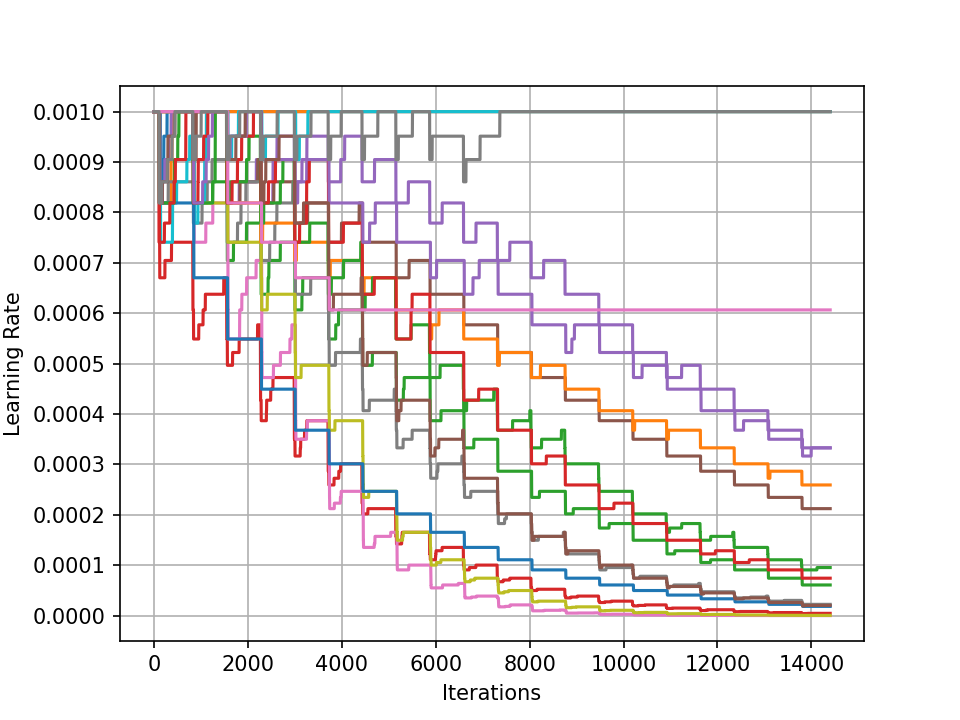

Text(0, 0.5, 'Learning Rate')

In [106]:
plt.figure()
class_id = 3
for p in range(n_protos):
    if mlvq.proto_labels[p] == class_id:
        plt.plot(mlvq.alpha_evolve[p])
plt.yticks(np.linspace(0,alpha_start,11))
plt.grid()

plt.xlabel("Iterations")
plt.ylabel("Learning Rate")

0.8187307530779818
1.0689391057472464


<IPython.core.display.Javascript object>


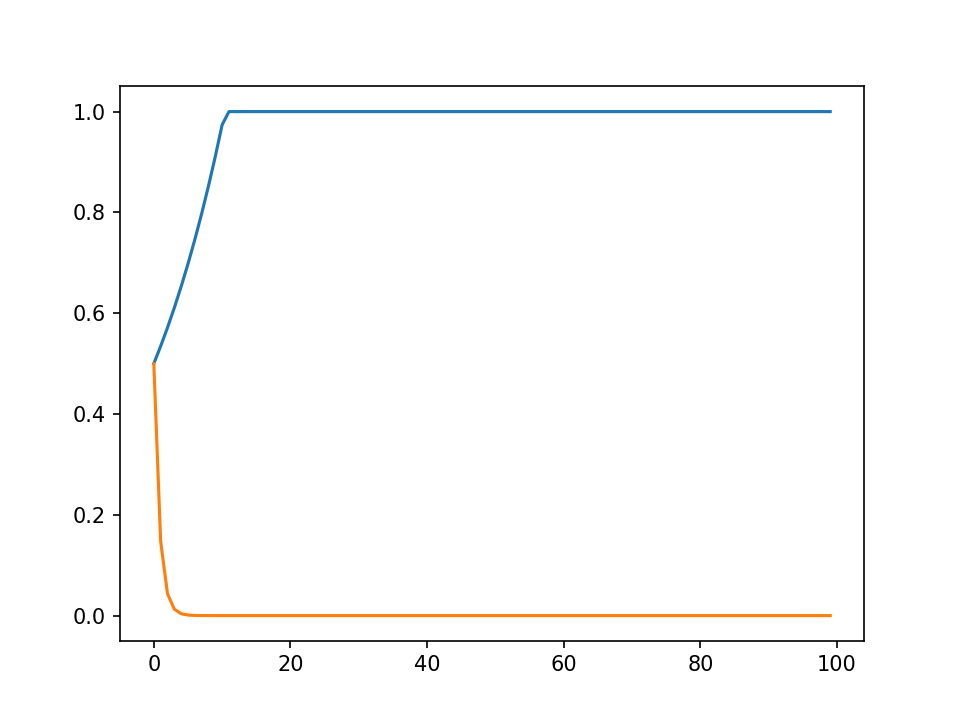

In [92]:
alpha_start = 0.5
tau_alpha_dc=5
tau_alpha_gr=15
alpha_dc = np.e ** (-1 / tau_alpha_dc)
alpha_gr = np.e ** (1 / tau_alpha_gr)
print(alpha_dc)
print(alpha_gr)
plt.figure()
growth = alpha_start*np.exp(np.arange(100)/tau_alpha_gr)
growth[growth>1]=1
plt.plot(growth)
plt.plot(alpha_start*np.exp(-np.arange(100)/alpha_dc))

In [39]:
importlib.reload(lvq.lvq3)
from lvq.lvq3 import LVQ3

n_epochs = 1
n_loop = 100
alpha = 0.02
alpha_decay = 'linear'
n_protos = 300

accs = np.zeros(shape=(n_tasks,n_tasks*n_loop))

mlvq3 = LVQ3(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                 n_protos=n_protos, 
                 n_class=n_class)

mlvq3.init_prototypes_from_data(X)

for loop in range(n_loop):
    for t in range(n_tasks):
        X_train = tasks[t][0]
        y_train = tasks[t][1]
        X_test = tasks[t][2]   
        y_test = tasks[t][3]


        mlvq3.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                               alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True, shuffle=False)

        for test_task in range(n_tasks):
            test_acc = mlvq3.predict(tasks[test_task][2], tasks[test_task][3])
            print("task ", test_task, " acc: ", test_acc)
            accs[test_task,loop*n_tasks+t] = test_acc
            
    print("Overall test accuracy: ", np.mean(accs[:,loop*n_tasks+n_tasks-1]))



TypeError: __init__() got an unexpected keyword argument 'rec_alpha_evolve'

<IPython.core.display.Javascript object>


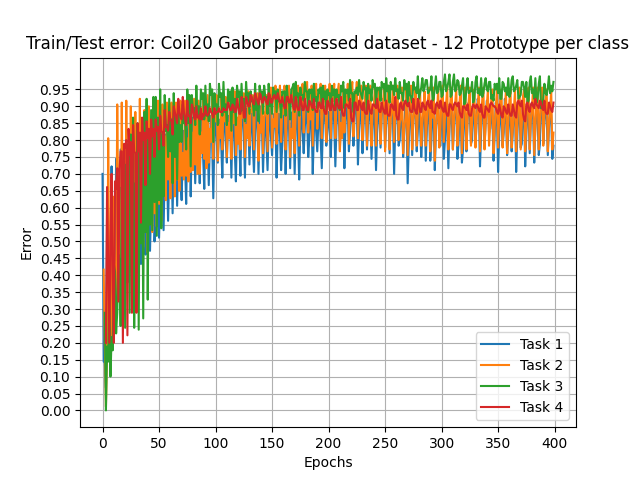

Text(0.5, 1.0, 'Train/Test error: Coil20 Gabor processed dataset - 12 Prototype per class')

In [81]:
plt.figure()
for t in range(n_tasks):
    plt.plot(np.arange(t,n_tasks*n_loop),accs[t,np.arange(t,n_tasks*n_loop)])
plt.yticks(np.arange(0,1,0.05))
plt.grid()

plt.legend(["Task 1",
           "Task 2",
           "Task 3",
           "Task 4"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Train/Test error: Coil20 Gabor processed dataset - 12 Prototype per class")

<IPython.core.display.Javascript object>


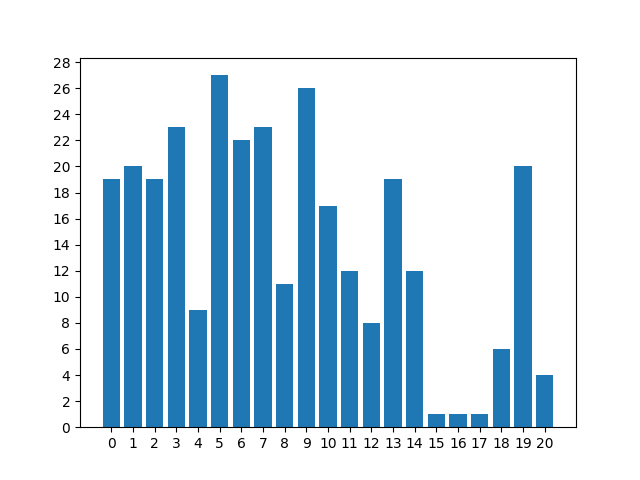

In [8]:
proto_labels = mlvq3.proto_labels.copy()
unique, counts = np.unique(proto_labels, return_counts=True)
plt.figure()
plt.bar(unique+1, counts)
plt.yticks(np.arange(0,30,2))
plt.xticks(np.arange(21))
plt.show()